In [1]:
# Standard library imports
import warnings
from collections import Counter
from datetime import datetime, timedelta

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from joblib import Parallel, delayed
from scipy.special import boxcox1p
from scipy.stats import boxcox, boxcox_normmax, skew, stats
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, 
                             precision_recall_fscore_support, precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

# Optuna specific imports
import optuna
from optuna.visualization import plot_optimization_history
from optuna.exceptions import TrialPruned


from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
# Setting warnings to ignore FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from collections import defaultdict


In [2]:
df=pd.read_csv('../data/BitcoinHeistDataPreProcessed.csv')

In [3]:
# The label Montreal is encoded as 0
# The label Panuda is encoded as 1
# The label Princeton is encoded as 2
# The label White is encoded as 3

# df1: designated attack (1)
# df2: other attacks (1)
# df3: white (0)

# Variable for designated attack
designated_attack = 2

# df1: designated attack (1)
df1 = df[df['label'] == designated_attack].copy()
df1['label'] = 1  # Transfer its original label to 1

# df2: other attacks (1)
df2 = df[(df['label'] != designated_attack) & (df['label'] != 3)].copy()
df2['label'] = 1  # Transfer other attacks’ label to 1

# df3: white (0)
df3 = df[df['label'] == 3].copy()

# Shuffle df3
df3 = df3.sample(frac=1, random_state=1)

# Calculate the number of samples for training and testing
num_train_samples = len(df2)
num_test_samples = len(df1)

# Split df3 into two parts for training and testing
df3_train = df3.iloc[:num_train_samples].copy()
#start at the row number equal to num_train_samples, and end at the row number equal to num_train_samples + num_test_samples".
df3_test = df3.iloc[num_train_samples:num_train_samples + num_test_samples].copy()

# Set the labels
df3_train['label'] = 0
df3_test['label'] = 0

# Create the training and testing dataframes
training_df = pd.concat([df2, df3_train])
test_df = pd.concat([df1, df3_test])

# For the training data
X_train = training_df.drop('label', axis=1)
y_train = training_df['label']

# For the test data
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
# #Montreal
# selected_features = ['address', 'year', 'day', 'length', 'neighbors', 'income',
#        'n_address_feature', 'day_of_week', 'average_income_per_transaction',
#        'transaction_count', 'merge_behavior', 'length_weight', 'week',
#        'total_volume', 'average_volume', 'transaction_frequency']

# X_train = X_train[selected_features]
# X_test = X_test[selected_features]

# # Update the feature names to match the selected features
# selected_feature_names = X_train.columns
# print('Updated X_train with selected features: {}'.format(selected_feature_names))

# selected_feature_names = X_test.columns
# print('Updated X_test with selected features: {}'.format(selected_feature_names))

In [5]:
# #Padua
# selected_features = ['address', 'year', 'day', 'neighbors', 'income', 'n_address_feature',
#        'day_of_week', 'average_income_per_transaction', 'transaction_count',
#        'merge_behavior', 'week', 'total_volume', 'average_volume',
#        'transaction_frequency']

# X_train = X_train[selected_features]
# X_test = X_test[selected_features]

# # Update the feature names to match the selected features
# selected_feature_names = X_train.columns
# print('Updated X_train with selected features: {}'.format(selected_feature_names))

# selected_feature_names = X_test.columns
# print('Updated X_test with selected features: {}'.format(selected_feature_names))

In [6]:
# Princeton
selected_features = ['address', 'year', 'day', 'length', 'weight', 'neighbors', 'income',
       'n_address_feature', 'day_of_week', 'average_income_per_transaction',
       'transaction_count', 'looped_ratio', 'total_volume', 'average_volume',
       'transaction_frequency']

X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Update the feature names to match the selected features
selected_feature_names = X_train.columns
print('Updated X_train with selected features: {}'.format(selected_feature_names))

selected_feature_names = X_test.columns
print('Updated X_test with selected features: {}'.format(selected_feature_names))

Updated X_train with selected features: Index(['address', 'year', 'day', 'length', 'weight', 'neighbors', 'income',
       'n_address_feature', 'day_of_week', 'average_income_per_transaction',
       'transaction_count', 'looped_ratio', 'total_volume', 'average_volume',
       'transaction_frequency'],
      dtype='object')
Updated X_test with selected features: Index(['address', 'year', 'day', 'length', 'weight', 'neighbors', 'income',
       'n_address_feature', 'day_of_week', 'average_income_per_transaction',
       'transaction_count', 'looped_ratio', 'total_volume', 'average_volume',
       'transaction_frequency'],
      dtype='object')


Accuracy: 0.4742068694284216
Prediction time: 6.949120998382568 seconds
Precision: 0.3247005930540304
Recall: 0.4742068694284216
F1 score: 0.3317189132656944


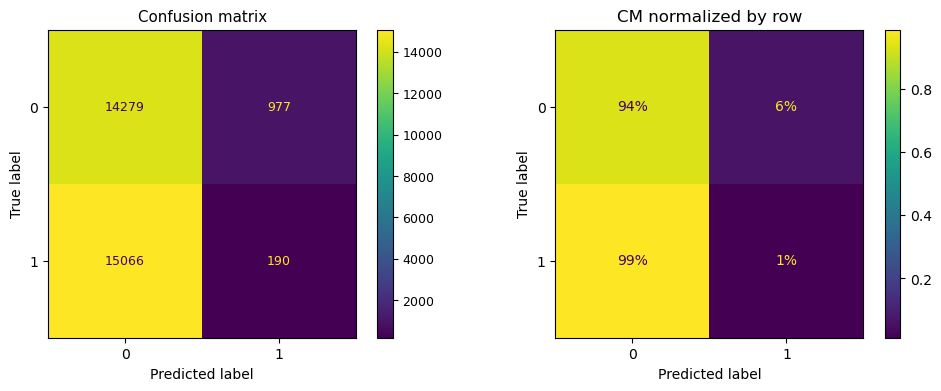

<Figure size 640x480 with 0 Axes>

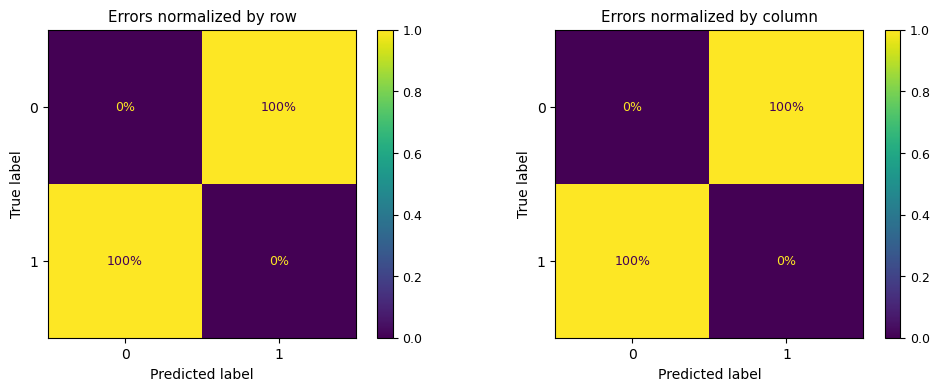

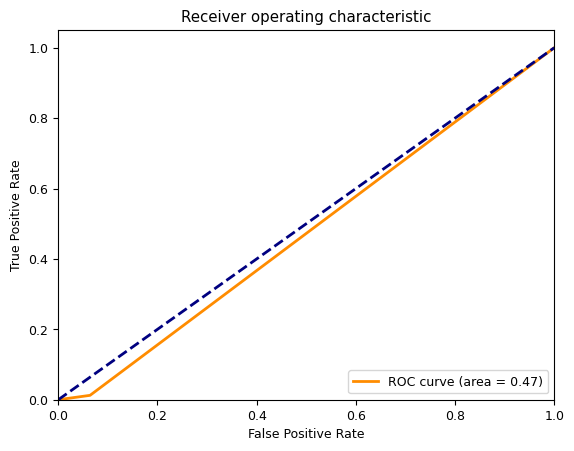

In [7]:
# Import the necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import time
import numpy as np

# Instantiate the SVM Classifier
model = SVC()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
start_time = time.time()
y_pred = model.predict(X_test)
end_time = time.time()

# Compute the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
prediction_time = end_time - start_time
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Prediction time:', prediction_time, 'seconds')
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f_score)

# Confusion Matrix and save it as PDF
sample_weight = (y_pred != y_test)

with PdfPages('SVM_Confusion_matrix_Princeton.pdf') as pdf:
    # Part 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs[0])
    axs[0].set_title("Confusion matrix")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", values_format=".0%", ax=axs[1])
    axs[1].set_title("CM normalized by row")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

    plt.clf()  # clear the figure for the next plot

    # Part 2
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize="true", values_format=".0%", ax=axs[0])
    axs[0].set_title("Errors normalized by row")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize="pred", values_format=".0%", ax=axs[1])
    axs[1].set_title("Errors normalized by column")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

# ROC Curve and save it as PDF
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)
with PdfPages('SVM_roc_Princeton.pdf') as pdf:
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    pdf.savefig(plt.gcf())  # Save the figure to PDF first
    plt.show()  # Then display the figure

plt.rc('font', size=14)  # make fonts great again


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters:  {'svc__C': 4.119839624605186, 'svc__gamma': 0.09960912999234932, 'svc__kernel': 'rbf'}
Accuracy: 0.47610776088096485
Prediction time: 7.672613143920898 seconds
Precision: 0.31941320133803075
Recall: 0.47610776088096485
F1 score: 0.33098147919841114


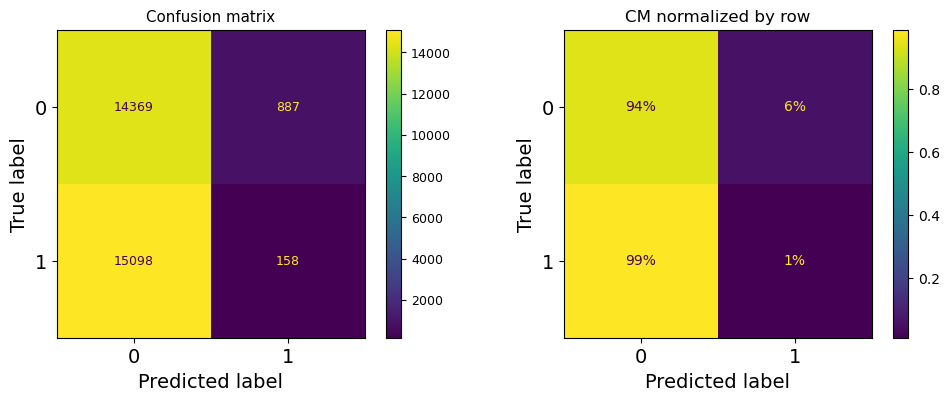

<Figure size 640x480 with 0 Axes>

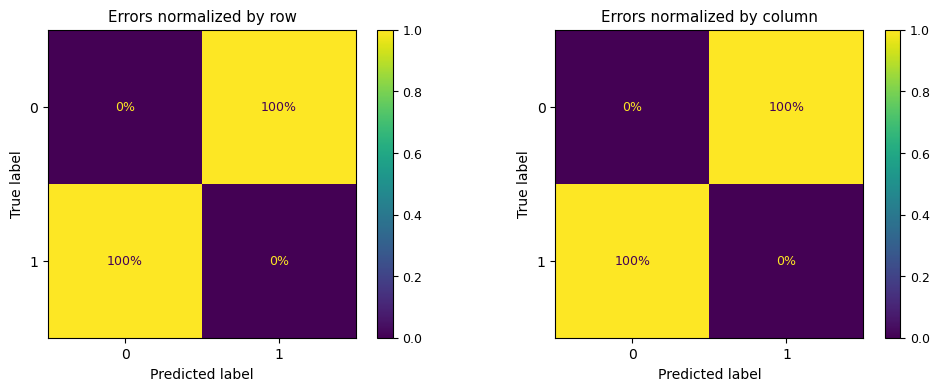

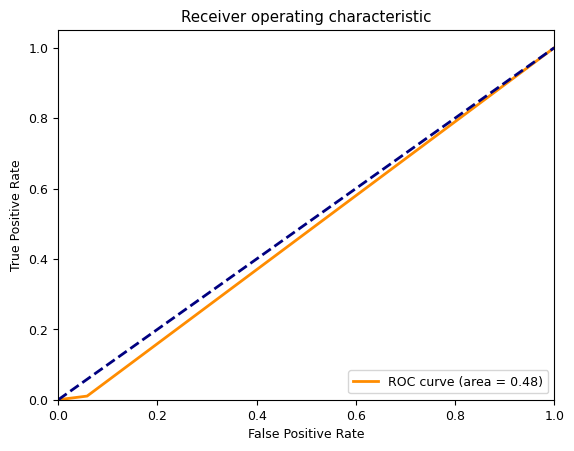

In [8]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import reciprocal, uniform

# First, create a smaller stratified sample of your training data
X_tune, _, y_tune, _ = train_test_split(X_train, y_train, stratify=y_train, test_size=0.9, random_state=42)

# Create a pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

# Parameter grid to pass in RandomizedSearchCV
param_distributions = {'svc__C': reciprocal(0.1, 10), 'svc__gamma': uniform(0.01, 0.1), 'svc__kernel': ['rbf', 'linear']}

# Use accuracy to optimize
scoring = 'accuracy'

# Instantiate RandomizedSearchCV with the required parameters
random_search = RandomizedSearchCV(pipe, param_distributions=param_distributions, n_iter=50, scoring=scoring, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit data to RandomizedSearchCV
random_search.fit(X_tune, y_tune)

# Get the optimal parameters
best_params = random_search.best_params_

print("Best parameters: ", best_params)

# Build model with best parameters
model = SVC(C=best_params['svc__C'], gamma=best_params['svc__gamma'], kernel=best_params['svc__kernel'])

# Fit the model on the full training data with the best parameters found
model.fit(X_train, y_train)

# Make predictions on the test data
start_time = time.time()
y_pred = model.predict(X_test)
end_time = time.time()

# Compute the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
prediction_time = end_time - start_time
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Prediction time:', prediction_time, 'seconds')
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f_score)

# Confusion Matrix and save it as PDF
sample_weight = (y_pred != y_test)

with PdfPages('SVM_Confusion_matrix_tuned_Princeton.pdf') as pdf:
    # Part 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs[0])
    axs[0].set_title("Confusion matrix")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", values_format=".0%", ax=axs[1])
    axs[1].set_title("CM normalized by row")
    plt.show()
    pdf.savefig(fig)

    plt.clf()

    # Part 2
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize="true", values_format=".0%", ax=axs[0])
    axs[0].set_title("Errors normalized by row")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize="pred", values_format=".0%", ax=axs[1])
    axs[1].set_title("Errors normalized by column")
    plt.show()
    pdf.savefig(fig)

# ROC Curve and save it as PDF
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)
with PdfPages('SVM_roc_tuned_Princeton.pdf') as pdf:
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    pdf.savefig(plt.gcf())
    plt.show()

plt.rc('font', size=14)
